<a href="https://colab.research.google.com/github/i-am-Aryan-Raj/Fine-Tuning-LLM-for-Q-A/blob/main/QA_ALBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
# !pip install transformers --quiet
# !pip install torch --quiet
# !pip install datasets --quiet
# !pip install peft --quiet
# !pip install accelerate -U --quiet
# !pip install tqdm --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 67.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.1/314.1 kB 10.3 MB/s eta 0:00:00


In [1]:
from transformers import AutoTokenizer, AlbertForQuestionAnswering, pipeline
import torch

In [2]:
tokenizer = AutoTokenizer.from_pretrained("twmkn9/albert-base-v2-squad2")
model = AlbertForQuestionAnswering.from_pretrained("twmkn9/albert-base-v2-squad2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the model checkpoint at twmkn9/albert-base-v2-squad2 were not used when initializing AlbertForQuestionAnswering: ['albert.pooler.bias', 'albert.pooler.weight']
- This IS expected if you are initializing AlbertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForQues

In [3]:
question, text = "What is my name?", "I am Aryan Raj."

In [4]:
inputs = tokenizer(question, text, return_tensors="pt")
with torch.no_grad():
    outputs = model(**inputs)

answer_start_index = outputs.start_logits.argmax()
answer_end_index = outputs.end_logits.argmax()

predict_answer_tokens = inputs.input_ids[0, answer_start_index : answer_end_index + 1]
tokenizer.decode(predict_answer_tokens, skip_special_tokens=True)

'aryan raj'

In [5]:
# !pip install datasets --quiet

In [6]:
from datasets import load_dataset
squad_v2 = load_dataset('squad_v2')

Generating train split:   0%|          | 0/130319 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11873 [00:00<?, ? examples/s]

In [7]:
def has_answer(example):
    return len(example['answers']['text']) > 0

# Filter the training and validation sets
squad_v2 = squad_v2.filter(has_answer)
# Check the number of examples in the filtered datasets
print(f"Number of examples after filtering: {len(squad_v2)}")

Filter:   0%|          | 0/130319 [00:00<?, ? examples/s]

Filter:   0%|          | 0/11873 [00:00<?, ? examples/s]

Number of examples after filtering: 2


#Visualising Squad v2

In [8]:
# Check the structure of the dataset
print(squad_v2)

# Display the first few examples from the training set
print(squad_v2['train'][0])

# Display the first few examples from the validation set
print(squad_v2['validation'][0])


DatasetDict({
    train: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 86821
    })
    validation: Dataset({
        features: ['id', 'title', 'context', 'question', 'answers'],
        num_rows: 5928
    })
})
{'id': '56be85543aeaaa14008c9063', 'title': 'Beyoncé', 'context': 'Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Cra

In [9]:
import pandas as pd

# Convert training data to DataFrame
train_df = pd.DataFrame(squad_v2['train'])

# Convert validation data to DataFrame
validation_df = pd.DataFrame(squad_v2['validation'])


In [10]:
train_df.head(2)

,id,title,context,question,answers
0,56be85543aeaaa14008c9063,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,"{'text': ['in the late 1990s'], 'answer_start'..."
1,56be85543aeaaa14008c9065,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,"{'text': ['singing and dancing'], 'answer_star..."


In [11]:
train_df['context'][1]

'Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny\'s Child. Managed by her father, Mathew Knowles, the group became one of the world\'s best-selling girl groups of all time. Their hiatus saw the release of Beyoncé\'s debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".'

In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86821 entries, 0 to 86820
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        86821 non-null  object
 1   title     86821 non-null  object
 2   context   86821 non-null  object
 3   question  86821 non-null  object
 4   answers   86821 non-null  object
dtypes: object(5)
memory usage: 3.3+ MB


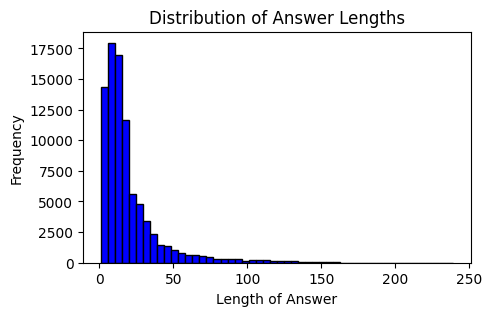

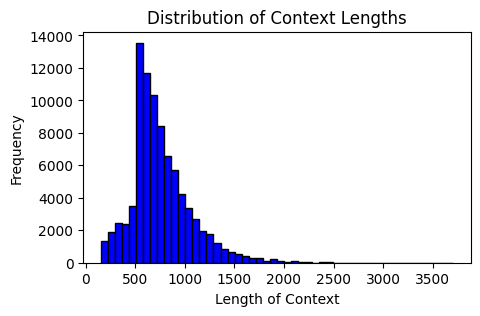

In [13]:
import matplotlib.pyplot as plt

# Length of each answer
answer_lengths = [len(answer) for answers in train_df['answers'] for answer in answers['text']]
# answer_lengths = [len(answers) for answers in train_df['question']]
plt.figure(figsize=(5, 3))
plt.hist(answer_lengths, bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Answer Lengths')
plt.xlabel('Length of Answer')
plt.ylabel('Frequency')
plt.show()


context_lengths = [len(answers) for answers in train_df['context']]
plt.figure(figsize=(5, 3))
plt.hist(context_lengths, bins=50, color='blue', edgecolor='black')
plt.title('Distribution of Context Lengths')
plt.xlabel('Length of Context')
plt.ylabel('Frequency')
plt.show()

#Performance

In [14]:
# Define the question-answering pipeline
nlp = pipeline('question-answering', model=model, tokenizer=tokenizer)

In [15]:

from tqdm import tqdm
import numpy as np

# Prepare lists to hold true answers and predicted answers
def generate_predictions_and_references(validation_df, nlp, sample_size=200):
    predictions = []
    references = []

    # Evaluate on a subset of the validation DataFrame
    for index, row in tqdm(validation_df.sample(sample_size).iterrows(), total=sample_size):
        context = row['context']
        question = row['question']
        qid = row['id']
        true_answers = row['answers']['text']

        # Get the model's prediction
        result = nlp(question=question, context=context)
        predictions.append({
            'id': qid,
            'prediction_text': result['answer'],
            'no_answer_probability': result.get('score', 0.0)  # Default no_answer_probability to 0.0 if not present
        })

        references.append({
            'id': qid,
            'answers': {'answer_start': row['answers']['answer_start'], 'text': true_answers}
        })

    return predictions, references

In [16]:
predictions, references = generate_predictions_and_references(validation_df, nlp, sample_size=200)

100%|██████████| 200/200 [01:25<00:00,  2.35it/s]


In [17]:
from datasets import load_metric, Dataset
metric = load_metric('squad_v2')

# Compute the metrics
final_score = metric.compute(predictions=predictions, references=references)
final_score

<ipython-input-17-82b6bd6ad7aa>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric('squad_v2')


The repository for squad_v2 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/squad_v2.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


{'exact': 82.0,
 'f1': 90.77034040520883,
 'total': 200,
 'HasAns_exact': 82.0,
 'HasAns_f1': 90.77034040520883,
 'HasAns_total': 200,
 'best_exact': 82.0,
 'best_exact_thresh': 0.998734712600708,
 'best_f1': 90.77034040520881,
 'best_f1_thresh': 0.998734712600708}

#Fine Tuning

In [18]:
# !pip install peft --quiet

In [19]:
from peft import LoraConfig, get_peft_model
from transformers import TrainingArguments, Trainer
lora_config = LoraConfig(
    r=16,  # Rank of the low-rank matrices
    lora_alpha=32,  # LoRA alpha parameter
    target_modules=["query", "key", "value"],  # Target modules for LoRA
    lora_dropout=0.1  # Dropout rate for LoRA layers
)

peft_model = get_peft_model(model, lora_config)
peft_model.print_trainable_parameters()


trainable params: 73,728 || all params: 11,168,258 || trainable%: 0.6602


##Preprocessing

In [20]:
def preprocess_data(examples):
    questions = [q.strip() for q in examples['question']]
    inputs = tokenizer(
        questions,
        examples['context'],
        max_length=384,
        truncation=True,
        padding="max_length",
        return_offsets_mapping=True
    )
    # Generate start and end positions
    start_positions = []
    end_positions = []
    for i, answer in enumerate(examples['answers']):
        if len(answer['answer_start']) > 0:
            start_positions.append(answer['answer_start'][0])
            end_positions.append(answer['answer_start'][0] + len(answer['text'][0]))
        else:
            start_positions.append(0)
            end_positions.append(0)
    inputs['start_positions'] = start_positions
    inputs['end_positions'] = end_positions
    return inputs

# Assuming train_df and validation_df are already loaded pandas DataFrames
# train_inputs = preprocess_data(squad_v2['train'], tokenizer)
# val_inputs = preprocess_data(squad_v2['validation'], tokenizer)



In [21]:
train_inputs = squad_v2['train'].map(preprocess_data, batched=True)
val_inputs = squad_v2['validation'].map(preprocess_data, batched=True)

Map:   0%|          | 0/86821 [00:00<?, ? examples/s]

Map:   0%|          | 0/5928 [00:00<?, ? examples/s]

In [22]:
# # Convert to datasets
# train_dataset = Dataset.from_dict(train_inputs)
# val_dataset = Dataset.from_dict(val_inputs)

In [23]:
# !pip install accelerate -U

In [24]:
def compute_metrics(p):
    start_logits, end_logits = p.predictions
    start_positions = p.label_ids[:, 0]
    end_positions = p.label_ids[:, 1]

    predictions = []
    references = []

    for i in range(len(start_positions)):
        start_pred = start_logits[i].argmax()
        end_pred = end_logits[i].argmax()
        input_ids = p.inputs['input_ids'][i]  # Access the input_ids from the predictions
        predictions.append({
            "id": str(i),
            "prediction_text": tokenizer.decode(input_ids[start_pred:end_pred+1])
        })
        references.append({
            "id": str(i),
            "answers": {
                "answer_start": [start_positions[i].item()],
                "text": [tokenizer.decode(input_ids[start_positions[i]:end_positions[i]+1])]
            }
        })

    return metric.compute(predictions=predictions, references=references)

In [25]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=3e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [26]:
small_train_dataset = train_inputs.select(range(5000))  # Adjust the range as needed
small_val_dataset = val_inputs.select(range(1000))  # Adjust the range as needed


In [27]:
# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_val_dataset,
    tokenizer=tokenizer
    # compute_metrics=compute_metrics
)

# Train the model
trainer.train()


Epoch,Training Loss,Validation Loss
1,5.948800,5.945599
2,5.859000,5.906612
3,5.877100,5.896644


TrainOutput(global_step=939, training_loss=6.9146342820887625, metrics={'train_runtime': 955.4437, 'train_samples_per_second': 15.7, 'train_steps_per_second': 0.983, 'total_flos': 250990824960000.0, 'train_loss': 6.9146342820887625, 'epoch': 3.0})

In [28]:
nlp_peft = pipeline('question-answering', model=peft_model, tokenizer=tokenizer)

The model 'PeftModel' is not supported for question-answering. Supported models are ['AlbertForQuestionAnswering', 'BartForQuestionAnswering', 'BertForQuestionAnswering', 'BigBirdForQuestionAnswering', 'BigBirdPegasusForQuestionAnswering', 'BloomForQuestionAnswering', 'CamembertForQuestionAnswering', 'CanineForQuestionAnswering', 'ConvBertForQuestionAnswering', 'Data2VecTextForQuestionAnswering', 'DebertaForQuestionAnswering', 'DebertaV2ForQuestionAnswering', 'DistilBertForQuestionAnswering', 'ElectraForQuestionAnswering', 'ErnieForQuestionAnswering', 'ErnieMForQuestionAnswering', 'FalconForQuestionAnswering', 'FlaubertForQuestionAnsweringSimple', 'FNetForQuestionAnswering', 'FunnelForQuestionAnswering', 'GPT2ForQuestionAnswering', 'GPTNeoForQuestionAnswering', 'GPTNeoXForQuestionAnswering', 'GPTJForQuestionAnswering', 'IBertForQuestionAnswering', 'LayoutLMv2ForQuestionAnswering', 'LayoutLMv3ForQuestionAnswering', 'LEDForQuestionAnswering', 'LiltForQuestionAnswering', 'LlamaForQuestion

In [41]:
predictions_peft, references_peft = generate_predictions_and_references(validation_df, nlp_peft, sample_size=5000)

100%|██████████| 5000/5000 [02:02<00:00, 40.86it/s]


In [42]:
peft_score = metric.compute(predictions=predictions_peft, references=references_peft)
peft_score

{'exact': 59.72,
 'f1': 69.48610644977147,
 'total': 5000,
 'HasAns_exact': 59.72,
 'HasAns_f1': 69.48610644977147,
 'HasAns_total': 5000,
 'best_exact': 59.72,
 'best_exact_thresh': 0.066996730864048,
 'best_f1': 69.48610644977151,
 'best_f1_thresh': 0.066996730864048}

#Sample Testing

In [38]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
peft_model.to(device)
question_new, text_new = train_df['question'][1], train_df['context'][1]

In [40]:
inputs_new = tokenizer(question_new, text_new, return_tensors="pt").to(device)
with torch.no_grad():
    outputs_new =peft_model(**inputs_new)

answer_start_index_new = outputs_new.start_logits.argmax()
answer_end_index_new = outputs_new.end_logits.argmax()

predict_answer_tokens_new = inputs_new.input_ids[0, answer_start_index_new : answer_end_index_new + 1]
tokenizer.decode(predict_answer_tokens_new, skip_special_tokens=True)

'singing and dancing'